In [45]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import glob
import xesmf as xe
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

from netCDF4 import Dataset

from numpy.linalg import svd
from scipy.stats import norm
from scipy.linalg import solve_triangular
import scipy.linalg as la
from scipy.linalg import det
from scipy.linalg import eigh 

from scipy.stats import wishart
import pandas as pd
import matplotlib.ticker as mticker

import os

# Define Functions

In [46]:
def eof_latlon(lon, lat, data_array, neof=5, idate=None, dname=None, alpha=0.05, subtract_mean=True):
    """
    Compute Principal Components (EOFs) of a data array.

    Parameters:
    lon : array-like
        Longitudes.
    lat : array-like
        Latitudes.
    data_array : array-like
        The data array in [space1, space2, time] or [space, time] format.
    neof : int, optional
        Number of spatial EOFs to output. Default is 5.
    idate : list, optional
        Vector indicating starting time and increment (e.g., [1, "JAN", 1979, "1MO"]).
    dname : str, optional
        Name of the dataset (e.g., "HADSST", "ERSSTv", etc.).
    alpha : float, optional
        Size of the confidence interval of explained variances: (1-alpha)*100%.
    subtract_mean : bool, optional
        Whether to remove the climatology (mean) from the data. Default is True.

    Returns:
    dict
        A dictionary containing EOFs, PCs, explained variance, confidence intervals, etc.
    """

    # Define dimensions
    nlon = len(lon)
    nlat = len(lat)
    lat = np.array(lat)  # Ensure lat is a NumPy array
    ntot = data_array.size // (nlon * nlat)

    if data_array.size % (nlon * nlat) != 0:
        raise ValueError("data_array dimensions are not an integral multiple of nlon * nlat")

    # Define weighting
    weight = np.sqrt(np.cos(np.radians(lat))).repeat(nlon)
    # Reshape data array to [space, time] if necessary
    data_array = data_array.reshape((nlon * nlat, -1))

    # Identify missing or zero-weighted data
    lbad = np.isnan(data_array.sum(axis=1)) | (weight == 0)

    # Remove climatology
    if subtract_mean:
        clim = np.nanmean(data_array, axis=1)
        data_array = data_array - clim[:, None]
    else:
        clim = np.full(nlon * nlat, np.nan)

    # Normalize/weight the variables
    data_array *= weight[:, None]

    # Compress data by eliminating missing grid points
    data_array = data_array[~lbad, :]
    ndef = np.sum(~lbad)

    # Perform SVD
    mmin = min(ndef, ntot, neof)
    u, s, vh = svd(data_array, full_matrices=False)

    # Compute explained variance
    fexpvar = s**2 / np.sum(s**2)

    # Compute confidence interval of explained variance
    stderr = norm.ppf(alpha / 2, loc=0, scale=1) * np.sqrt(2 / ntot)
    fexpvar_ci = np.column_stack([fexpvar * (1 - stderr), fexpvar * (1 + stderr)])

    # Compute PCs
    pc = np.sqrt(ntot - 1) * vh[:mmin, :].T

    # Fill in missing points in EOFs
    eof = np.full((nlon * nlat, mmin), np.nan)
    eofi = np.full((nlon * nlat, mmin), np.nan)
    for n in range(mmin):
        eof[~lbad, n] = u[:, n] / weight[~lbad] * s[n] / np.sqrt(ntot - 1)
        eofi[~lbad, n] = u[:, n] * weight[~lbad] / s[n] * np.sqrt(ntot - 1)

    # Return results as a dictionary
    return {
        "eof": eof,
        "pc": pc,
        "fexpvar": fexpvar,
        "fexpvar_ci": fexpvar_ci,
        "eofi": eofi,
        "neof": mmin,
        "lbad": lbad,
        "weight": weight,
        "lon": lon,
        "lat": lat,
        "sval": s,
        "idate": idate,
        "dname": dname,
        "clim": clim
    }



In [47]:
### corrected gev function
def gev(A, B):
    # Computes generalized eigenvalue problem A*x=lambda*B*x
    # INPUT:
    # Two matrices A(ntrun,ntrun) and B(ntrun,ntrun)

    # OUTPUT:
    #  q(ntrun,ntrun): projection vectors for the APT-optimals
    #  lambda(ntrun) : eigen-values

    # Check if A and B are the same dimension square matrices!
    if A.size == 1:
        if B.size != 1:
            raise ValueError('A and B not dimensioned correctly')
        lambda_ = A / B
        q = np.array([1])
    else:
        if A.shape != B.shape:
            raise ValueError("dim(A)!=dim(B)")
        if A.shape[0] != A.shape[1]:
            raise ValueError("A is not square")

        lprint = True
        ntrun = A.shape[0]

        # Cholesky decomposition B = U^T U.
        B_chol = (np.linalg.cholesky(B)).T

        # Whitened A = (U^T)^(-1) A U^(-1)
        A_white = la.solve_triangular(B_chol.T, (la.solve_triangular(B_chol.T, A, lower=True)).T,  lower=True)

        # Eigen vectors of whitened A 
        ##eigen_chol = np.linalg.eigvalsh(A_white) ##didnt work
        eigenvalues, eigenvectors = np.linalg.eigh(A_white)

        # Reverse order to match R
        eigenvalues = eigenvalues[::-1]
        eigenvectors = eigenvectors[:, ::-1]

        # Manually adjust signs to match R output
        #eigenvectors[:, 0] = -eigenvectors[:, 0]
        eigenvectors = -eigenvectors


        # Transform eigenvectors evec = U^(-1) evec.white
        q = la.solve_triangular(B_chol, eigenvectors, lower=False)

        # Normalize vectors to qTBq = 1
        amp = np.sqrt(np.sum(q * (B @ q), axis=0))

        # Normalize vectors
        q = q / amp

        # Eigen-values
        lambda_ = eigenvalues

    # if (lprint) print("Generalized e-value problem finished")
    return {'lambda': lambda_, 'q': q}



In [48]:
def discr_pca(xmat, ymat, eof_list):
    """
    Performs covariance discriminant analysis.
    INPUT:
        xmat [time, neof]: Data array for X
        ymat [time, neof]: Data array for Y
        eof_list: Output list from EOF analysis
    OUTPUT:
        Dictionary containing:
            mic [neof]: Mutual information criterion
            nmin: Location of minimum MIC
            discr_ratio [neof]: Discriminant ratios
            rx: Discriminant projections for xmat
            ry: Discriminant projections for ymat
            pmat: Projection matrix for EOFs
    """
    dof_x = xmat.shape[0]
    dof_y = ymat.shape[0]
    ndim = xmat.shape[1]
    if ndim != ymat.shape[1]:
        raise ValueError("x and y have inconsistent dimensions")
    
    dof_t = dof_x + dof_y
    cov_x = np.cov(xmat, rowvar=False) * (dof_x - 1) / dof_x
    cov_y = np.cov(ymat, rowvar=False) * (dof_y - 1) / dof_y
    cov_t = (dof_x * cov_x + dof_y * cov_y) / dof_t
    
    mic = np.full(ndim, np.nan)
    for n in range(1, ndim + 1):
        if min(dof_x, dof_y) - n - 2 > 0:
            mic[n - 1] = (
                dof_x * np.log(det(cov_x[:n, :n])) +
                dof_y * np.log(det(cov_y[:n, :n])) -
                dof_t * np.log(det(cov_t[:n, :n])) +
                n * dof_x * (dof_x + 1) / (dof_x - n - 2) +
                n * dof_y * (dof_y + 1) / (dof_y - n - 2) -
                n * dof_t * (dof_t + 1) / (dof_t - n - 2)
            )
    
    mic = mic / dof_t
    nmin = np.nanargmin(mic) + 1
    
    # Adjust covariance matrices for GEV computation
    cov_x *= dof_x / (dof_x - 1)
    cov_y *= dof_y / (dof_y - 1)
    
    gev_result = gev(cov_x[:nmin, :nmin], cov_y[:nmin, :nmin])
    discr_ratio = gev_result['lambda']
    rx = xmat[:, :nmin] @ gev_result['q']
    ry = ymat[:, :nmin] @ gev_result['q']
    pmat = eof_list['eof'][:, :nmin] @ cov_y[:nmin, :nmin] @ gev_result['q']
    
    return {
        'mic': mic,
        'nmin': nmin,
        'discr_ratio': discr_ratio,
        'rx': rx,
        'ry': ry,
        'pmat': pmat
    }

# Importing data

In [49]:
dir_data = '/scratch/asarker3/clim680/conv_data_181/'

In [50]:
# File path
filename = f"{dir_data}picontrol2.nc"
ncin = xr.open_dataset(filename)
ncin

/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/asarker3/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.Dataset>
Dimensions:  (time: 3600, lat: 181, lon: 361)
Coordinates:
  * time     (time) object 3550-01-16 12:00:00 ... 3849-12-16 12:00:00
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
Data variables:
    tos      (time, lat, lon) float32 ...

In [51]:
dat_ctr2 = ncin.variables['tos'][:]
lon = ncin.variables['lon'][:]
lat = ncin.variables['lat'][:]
time_ctr = ncin.variables['time'][:]
ncin.close()

In [52]:
nlon = len(lon)
nlat = len(lat)

In [53]:
# Remove the first 20 years (20 * 12 = 240 months)
dat_ctr2 = dat_ctr2[240:, :, :]  # Slice time dimension
print(f'Clipped the first 20 years. Remaining shape: {dat_ctr2.shape}')


Clipped the first 20 years. Remaining shape: (3360, 181, 361)


In [54]:
# Check if the remaining time is a multiple of 12 (for full years)
tdim_ctr1 = dat_ctr2.shape[0]
if tdim_ctr1 % 12 != 0:
    raise ValueError('Remaining time is not a multiple of 12 months.')
tdim_ctr = int(tdim_ctr1 / 12)

In [55]:
# Compute annual means
# Reshape to group months into years
dat_ctr2 = np.array(dat_ctr2)
dat_ctr2 = dat_ctr2.reshape(-1, 12, dat_ctr2.shape[1], dat_ctr2.shape[2])  # [years, months, lat, lon]
dat_ctr2.shape

(280, 12, 181, 361)

In [56]:
# Compute mean over the 12 months (axis=1)
dat_ctr_latlon = np.mean(dat_ctr2, axis=1)  # Resulting shape: [years, lat, lon]
print(f'Computed annual means. Resulting shape: {dat_ctr_latlon.shape}')

Computed annual means. Resulting shape: (280, 181, 361)


In [57]:
dat_ctr_transposed = np.transpose(dat_ctr_latlon, (1,2,  0))
row_means2 = dat_ctr_transposed.mean(axis=2)
print(row_means2.shape)
dat_ctr_clim = row_means2.reshape(-1)
dat_ctr = dat_ctr_transposed.reshape(-1, dat_ctr_transposed.shape[2])

(181, 361)


# Importing data from historical run for 10 ensmebles

In [58]:
nens = 10
dat_20c = None

for ne in range(1, nens + 1):
    filename = f"{dir_data}tos{ne}.nc"
    #print(filename)

    ncin = xr.open_dataset(filename)
    tas = ncin.variables['tos'][:]
    time_ens = ncin.variables['time'][:]
    tdim = len(time_ens)
    if tdim % 12 != 0:
        raise ValueError('Control time not a multiple of 12')
    tdim_ens = tdim // 12

    lon = ncin.variables['lon'][:]
    lat = ncin.variables['lat'][:]
    nlon = len(lon)
    nlat = len(lat)
    
    # Check if the remaining time is a multiple of 12 (for full years)
    tdim_ens1 = tas.shape[0]
    if tdim_ens1 % 12 != 0:
        raise ValueError('Remaining time is not a multiple of 12 months.')
    tdim_20c = int(tdim_ens1 / 12)
    # Compute annual means
    # Reshape to group months into years
    tas = np.array(tas)

    tas_reshaped = tas.reshape((tdim_20c,12,  nlat, nlon))

    # Now tas_reshaped has the desired shape

    tas_annual = np.mean(tas_reshaped , axis=1)

    tas_transposed = np.transpose(tas_annual, (1,2,  0))  # Reorder axes
    tas_flattened_lat_lon_time = tas_transposed.reshape(-1, tas_transposed.shape[2])

    tas_flattened = tas_annual.reshape(-1)
    
    if ne == 1:
        dat_20c = np.empty((nlon * nlat , tdim_20c, nens))
    
    dat_20c[:,:, ne - 1] = tas_flattened_lat_lon_time
    

In [59]:
mean_ensemble = np.mean(dat_20c, axis=2)

# Check the shape of the result
print(mean_ensemble.shape)  
dat_20c_clim = np.mean(mean_ensemble, axis=1)

# Check the shape of the final result
print(dat_20c_clim.shape) 

(65341, 165)
(65341,)


In [60]:
dat_ctr_clim_expanded = dat_ctr_clim[:, np.newaxis]  # Add a new axis
result_clim = dat_ctr[:, :tdim_20c] - dat_ctr_clim_expanded
print(result_clim.shape)  

(65341, 165)


In [61]:
dat_20c_clim_expanded = dat_20c_clim[:, np.newaxis]
result_20c = dat_20c[:, :tdim_20c, 0] - dat_20c_clim_expanded

# COMPUTING EOFS

In [62]:
a = np.column_stack((result_clim, result_20c))
print(a.shape)
idate = [1, 'jan', 1850, "1yr"]

(65341, 330)


In [63]:
neof=50
eof_list = eof_latlon(lon,lat,a,neof=neof,idate=idate,dname="ipsl")

/tmp/ipykernel_870453/1511300981.py:47: RuntimeWarning: Mean of empty slice
  clim = np.nanmean(data_array, axis=1)


In [64]:
print(eof_list.keys())

dict_keys(['eof', 'pc', 'fexpvar', 'fexpvar_ci', 'eofi', 'neof', 'lbad', 'weight', 'lon', 'lat', 'sval', 'idate', 'dname', 'clim'])


# PROJECT EOFS

In [65]:
dat_reordered = np.transpose(dat_20c, (0, 2, 1))  # Shape becomes (65341, 3, 165)

# Reshape so that ensemble values are stacked sequentially
dat_20c = dat_reordered.reshape(65341, -1)  # Shape becomes (65341, 495)

# Check the shape
print(dat_20c.shape)  # Output: (65341, 495) # The -1 automatically calculates the size of the second dimension

(65341, 1650)


In [66]:
valid_indices = ~eof_list["lbad"]  # Negate the bad data mask to get valid indices

In [67]:
# Extract only valid data points for each dataset
dat_20c_valid = dat_20c[valid_indices,:]  # Select valid columns
dat_ctr_valid = dat_ctr[valid_indices,:]  # Select valid columns


In [68]:
eofi_valid = eof_list["eofi"][valid_indices, :]  # Select valid rows in EOF matrix

# Compute PCs
pc_20c = dat_20c_valid.T @ eofi_valid  # Transpose dat_20c_valid and multiply
pc_ctr = dat_ctr_valid.T @ eofi_valid  # Transpose dat_ctr_valid and multiply


In [69]:
print(pc_20c.shape)
print(pc_ctr.shape)
print(eofi_valid.shape)

(1650, 50)
(280, 50)
(43288, 50)


### Visualization of the First EOF and Its Principal Component

In [70]:
fig_folder = '/home/asarker3/clim680/project/figures'

In [71]:
years = np.arange(1850, 2015)

In [72]:
years_cntl = np.arange(1850, 2130)
years_cntl.shape

(280,)

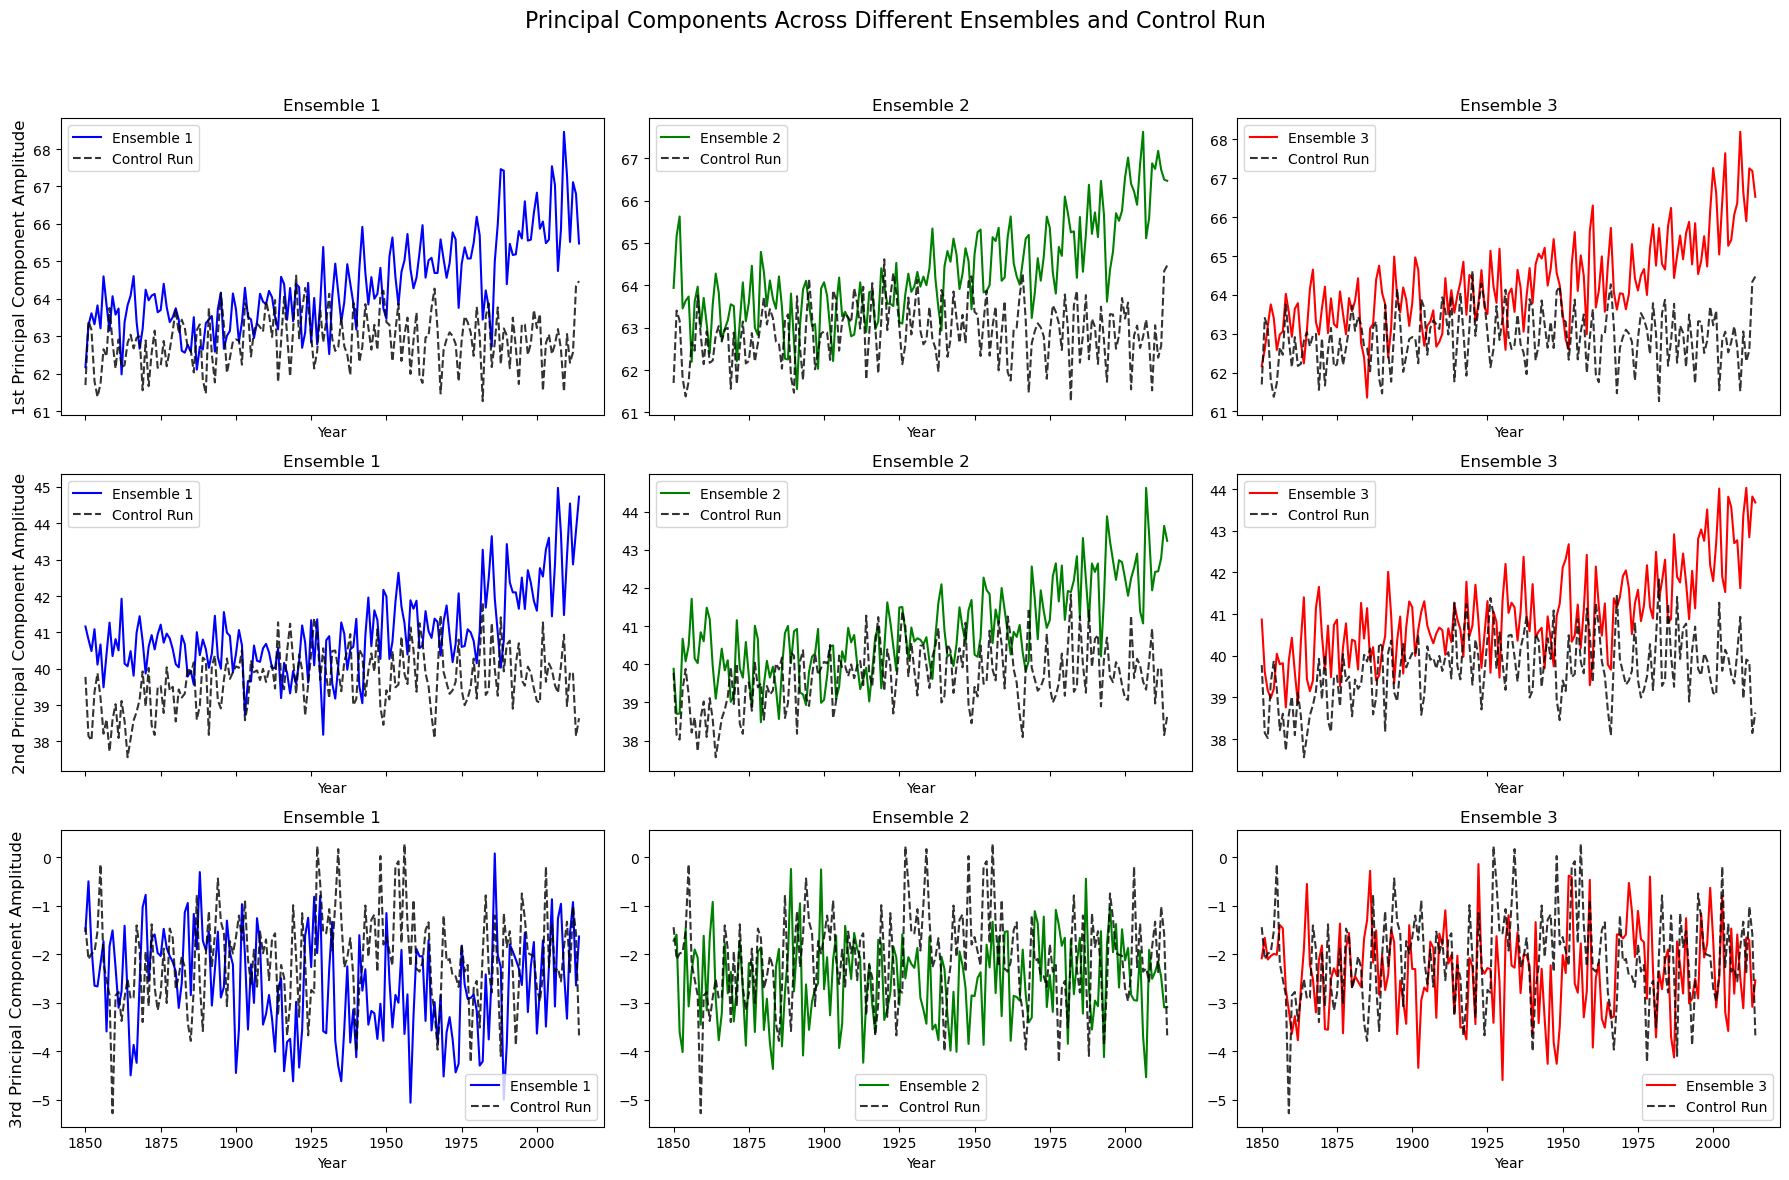

In [73]:
# Create a figure with 9 subplots (3 rows x 3 columns)
fig, axs = plt.subplots(3, 3, figsize=(18, 12), sharex=True, sharey=False)

# Titles for each row
row_titles = ["1st Principal Component", "2nd Principal Component", "3rd Principal Component"]

# Colors for ensembles
ensemble_colors = ['b', 'g', 'r']

# Loop through rows (Principal Components)
for i, pc_index in enumerate([0, 1, 2]):
    for j, color in enumerate(ensemble_colors):
        # Plot Ensemble data
        axs[i, j].plot(years[:165], pc_20c[j * 165:(j + 1) * 165, pc_index], color=color, label=f"Ensemble {j + 1}")
        # Plot Control data
        axs[i, j].plot(years[:165], pc_ctr[:165, pc_index], color='black', linestyle='--', alpha=0.8, label="Control Run")
        
        # Set titles and labels
        axs[i, j].set_title(f"Ensemble {j + 1}", fontsize=12)
        axs[i, j].set_xlabel("Year")
        if j == 0:  # Add ylabel only to the first column
            axs[i, j].set_ylabel(f"{row_titles[i]} Amplitude", fontsize=12)
        axs[i, j].legend(loc='best', fontsize=10)

# Set a main title for the entire figure
fig.suptitle("Principal Components Across Different Ensembles and Control Run", fontsize=16)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

#fig.savefig(os.path.join(fig_folder, 'pc3'))
plt.show()


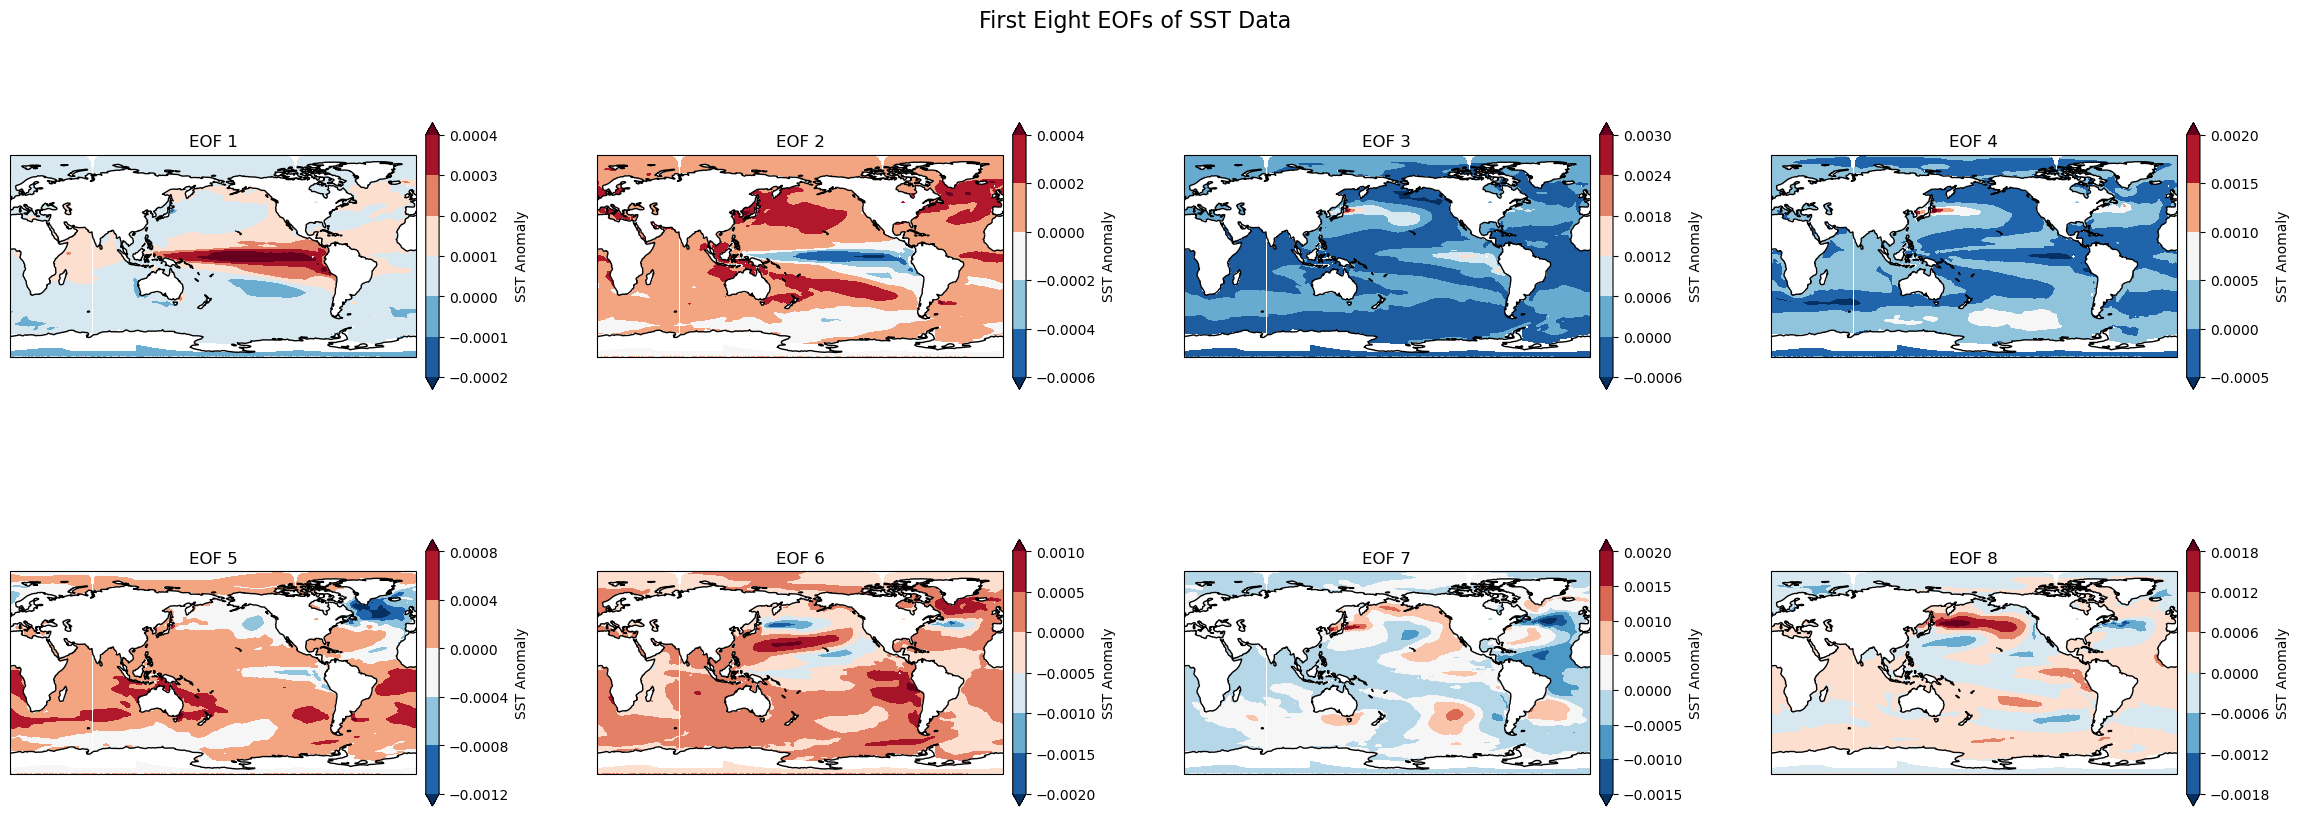

In [74]:
# Create the figure with 2 rows and 4 columns for the 7 EOFs
fig, axs = plt.subplots(nrows=2, ncols=4, 
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                        figsize=(25, 10))

# Flatten axs to iterate over the subplots
axs = axs.flatten()

# Loop through the first 7 EOFs
for i in range(8):
    # Select data for the current EOF
    plot_eof = eof_list['eofi'][:, i]
    unflattened_data = plot_eof.reshape((181, 361))

    # Add the cyclic point to avoid a gap in the map
    data, lons = add_cyclic_point(unflattened_data, coord=lon)

    # Plot contour for each EOF
    cs = axs[i].contourf(lons, lat, data, 
                         #levels=np.arange(-5, 5, 0.5), 
                         transform=ccrs.PlateCarree(),
                         cmap='RdBu_r', extend='both')

    # Set the title for each subplot
    axs[i].set_title(f'EOF {i+1}', fontsize=12)

    # Add coastlines
    axs[i].coastlines()

    # Add individual colorbar for each subplot
    cbar = fig.colorbar(cs, ax=axs[i], orientation='vertical', shrink=0.8, pad=0.02)
    cbar.set_label("SST Anomaly")

# Remove the unused subplot (8th in 2x4 grid)
#fig.delaxes(axs[-1])

# Adjust layout for better spacing (reduced gap between rows)
fig.subplots_adjust(bottom=0.15, top=0.9, left=0.05, right=0.95, wspace=0.2, hspace=0.25)

# Add a main title
plt.suptitle('First Eight EOFs of SST Data', fontsize=16)

#fig.savefig(os.path.join(fig_folder, 'eof8'))
plt.show()


In [75]:
# pc_20c has the shape (tdim_20c, nens, neof)
# Reshape it to (tdim_20c * nens, neof)

pc_20c_reshaped = pc_20c.reshape(tdim_20c * nens, neof)

# Check the shape after reshaping
print(pc_20c_reshaped.shape)  # Expected output: (tdim_20c * nens, neof)


(1650, 50)


# Compute Mutual Information Criteria (MIC)
### Checks if the variance ratio is significant

In [76]:
dof_ctr = pc_ctr.shape[0]
dof_20c = pc_20c.shape[0]
dof_tot = dof_ctr + dof_20c

# Calculate covariance matrices
cov_ctr = np.cov(pc_ctr, rowvar=False) * (dof_ctr - 1) / dof_ctr
cov_20c = np.cov(pc_20c, rowvar=False) * (dof_20c - 1) / dof_20c

# Calculate total covariance
cov_tot = (dof_ctr * cov_ctr + dof_20c * cov_20c) / dof_tot

In [77]:
mic = np.full(neof, np.nan)  # Initialize mic array with NaN values

# First loop to calculate the log determinant part
for ne in range(neof):
    mic[ne] = (dof_ctr * np.log(np.linalg.det(cov_ctr[:ne+1, :ne+1]))) + \
              (dof_20c * np.log(np.linalg.det(cov_20c[:ne+1, :ne+1]))) - \
              (dof_tot * np.log(np.linalg.det(cov_tot[:ne+1, :ne+1])))

# Second loop to calculate the correction term
for ne in range(neof):
    mic[ne] += (ne * (dof_ctr * (dof_ctr + 1) / (dof_ctr - ne - 2) + 
                     dof_20c * (dof_20c + 1) / (dof_20c - ne - 2) - 
                     dof_tot * (dof_tot + 1) / (dof_tot - ne - 2)))

# Find the index of the minimum value of mic
nmin = np.argmin(mic)

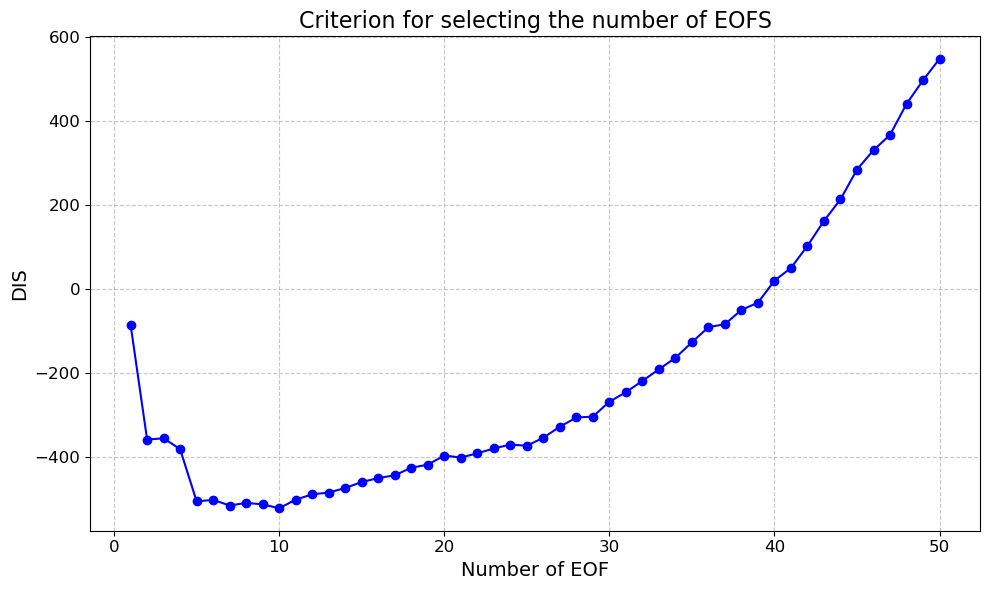

In [78]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(np.arange(1,51),mic, marker='o', linestyle='-', color='b')  # Add markers, line style, and color

# Add titles and labels
plt.title('Criterion for selecting the number of EOFS', fontsize=16)
plt.xlabel('Number of EOF', fontsize=14)
plt.ylabel('DIS', fontsize=14)

# Customize ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add grid and legend
plt.grid(visible=True, linestyle='--', alpha=0.7)
#plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
os.makedirs(fig_folder, exist_ok=True)
#plt.savefig(os.path.join(fig_folder, 'dis.png'))
plt.show()


In [79]:
discr_list = discr_pca(pc_20c,pc_ctr,eof_list)

# SOLVE GENERALIZED E.VALUE PROBLEM

In [80]:
cov_ctr = cov_ctr * dof_ctr / (dof_ctr - 1)
cov_20c = cov_20c * dof_20c / (dof_20c - 1)


gev_list = gev(cov_20c[:nmin+1, :nmin+1], cov_ctr[:nmin+1, :nmin+1])

r_20c = np.dot(pc_20c[:, :nmin+1], gev_list["q"])
r_ctr = np.dot(pc_ctr[:, :nmin+1], gev_list["q"])
pmat = np.dot(np.dot(eof_list["eof"][:, :nmin+1], cov_ctr[:nmin+1, :nmin+1]), gev_list["q"])

# Filtering based on !eof.list$lbad (assuming this is a boolean mask)
weight = eof_list['weight'][~eof_list['lbad']]

# Calculate total variance for 20C
var_tot_20c = np.sum(((dat_20c[~eof_list['lbad'], :] - dat_20c[~eof_list['lbad'], :].mean(axis=1)[:, np.newaxis]) * weight[:, np.newaxis])**2) / (dat_20c.shape[1] - 1)

# Calculate total variance for control
var_tot_ctr = np.sum(((dat_ctr[~eof_list['lbad'], :] - dat_ctr[~eof_list['lbad'], :].mean(axis=1)[:, np.newaxis]) * weight[:, np.newaxis])**2) / (dat_ctr.shape[1] - 1)

# Initialize arrays
fexpvar_20c = np.zeros(nmin) ##The fraction of variance explained by patterns for historical run
fexpvar_ctr = np.zeros(nmin) ##The fraction of variance explained by patterns for control run

# Calculate explained variance for 20C
for n in range(nmin):
    fexpvar_20c[n] = np.var(r_20c[:, n]) * np.sum((pmat[~eof_list['lbad'], n]**2 * weight**2)) / var_tot_20c

# Calculate explained variance for control
for n in range(nmin):
    fexpvar_ctr[n] = np.var(r_ctr[:, n]) * np.sum((pmat[~eof_list['lbad'], n]**2 * weight**2)) / var_tot_ctr

## MONTE CARLO 

In [81]:
# Parameters
alpha    = 0.05
ntrials = 1000
cov_identity = np.eye(nmin)  # Identity matrix with size (nmin x nmin)
lambda_mc = np.empty((nmin, ntrials))
np.random.seed(2)

# Monte Carlo simulation
for nt in range(ntrials):
    # Generate random Wishart-distributed matrices
    cov_x = wishart.rvs(df=dof_20c - 1, scale=cov_identity) / (dof_20c - 1)
    cov_y = wishart.rvs(df=dof_ctr - 1, scale=cov_identity) / (dof_ctr - 1)
    # Compute lambda using gev function
    lambda_mc[:, nt] = gev(cov_x, cov_y)["lambda"]

# Critical values
lambda_crit = np.empty((nmin, 2))
for n in range(nmin):
    lambda_crit[n, :] = np.quantile(lambda_mc[n, :], [alpha, 1 - alpha])

In [82]:
## Initial nmin shows the index for the optimal EOF, not number of EOFs. In zero based index 1 should be added
nmin = nmin+1

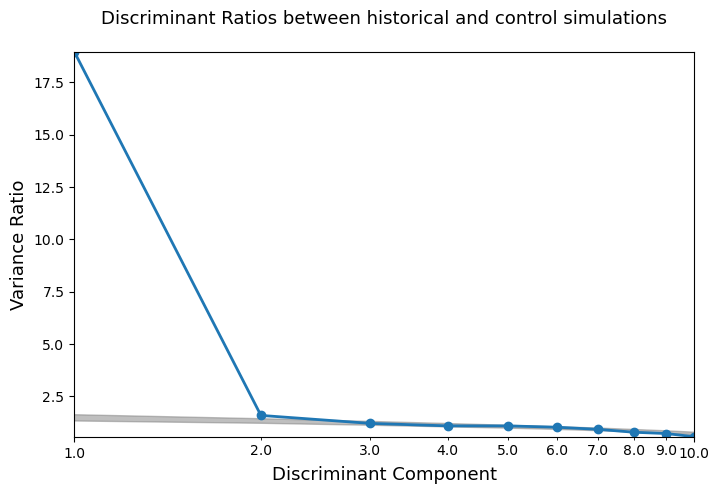

In [83]:
# Parameters
alpha    = 0.05
ntrials = 1000
cov_identity = np.eye(nmin)  # Identity matrix with size (nmin x nmin)
lambda_mc = np.empty((nmin, ntrials))
np.random.seed(2)

# Monte Carlo simulation
for nt in range(ntrials):
    # Generate random Wishart-distributed matrices
    cov_x = wishart.rvs(df=dof_20c - 1, scale=cov_identity) / (dof_20c - 1)
    cov_y = wishart.rvs(df=dof_ctr - 1, scale=cov_identity) / (dof_ctr - 1)
    # Compute lambda using gev function
    lambda_mc[:, nt] = gev(cov_x, cov_y)["lambda"]

# Critical values
lambda_crit = np.empty((nmin, 2))
for n in range(nmin):
    lambda_crit[n, :] = np.quantile(lambda_mc[n, :], [alpha, 1 - alpha])
    
# Plotting setup
plt.figure(figsize=(8, 5))
yrange = (min(gev_list["lambda"].min(), lambda_crit.min()), max(gev_list["lambda"].max(), lambda_crit.max()))
xrange = (1, nmin)

# Plotting the main curve
plt.plot(range(1, nmin + 1), gev_list["lambda"], marker='o', linestyle='-', linewidth=2, label="Variance Ratio")
plt.xlim(xrange)
plt.ylim(yrange)
plt.xscale('log')
plt.xlabel('Discriminant Component', fontsize=13)
plt.ylabel('Variance Ratio', fontsize=13)

# Adjust tick label formatting
plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter())
plt.ticklabel_format(style='plain', axis='both')

plt.gca().xaxis.set_minor_formatter(mticker.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(mticker.ScalarFormatter())
plt.ticklabel_format(style='plain', axis='both')


# Adding the shaded polygon
x_poly = np.concatenate([range(1, nmin + 1), range(nmin, 0, -1)])
y_poly = np.concatenate([lambda_crit[:, 0], lambda_crit[:, 1][::-1]])
plt.fill(x_poly, y_poly, color='grey', alpha=0.5, label="Confidence Interval")

# Adding title
ftitle_top = 'Discriminant Ratios between historical and control simulations'
plt.title(ftitle_top, fontsize=13, pad=20)    
#plt.savefig(os.path.join(fig_folder, 'var_ratio'))
plt.show()